# Neural Network Intro

Welcome to this assignment! We're going to learn some basics about neural networks.

## Tabel of Contents

- 1- Linear Regression
  - 1.1- Gas Station Problem
  - 1.2- Gradient Descent
- 2- Logistic Regression
  - 2.1- Binary Classification
  - 2.2- Softmax Regression
- 3- Neural Network
  - 3.1- Two Layer Neural Network
  - 3.2- Backpropagation
  - 3.3- RNN
- 4- Harry Potter Generation
  - 4.1- Dataset
  - 4.2- Train
  - 4.3- Results

In [1]:
from sklearn.metrics import r2_score, accuracy_score
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1- Linear Regression

Consider $f: \mathbb{R} \rightarrow \mathbb{R}$ is a linear function of $x \in \mathbb{R}$. So we can write $f(x) = wx$, where $w$ is an unknown scaler. We don't know the value of $w$, but we have some observed $x, y$ pairs. The task is to predict $w$ based on these datapoints.

### 1.1- Gas Station Problem

We've collected a dataset from [Gas Station No. 240](https://g.co/kgs/3unyyWR). For $4$ lines of this station, we mesured the time each car exits the line. There are $21$ exit times for each line.

We want to convert this dataset to $\mathcal{D}=\{x^{(i)}, y^{(i)}\}_{i=1}^n$ where $x$ denotes the $x$-th car exits from an arbitrary line, and $y$ is the wating time in seconds, starts from exiting the first car of the coherent line. Our goal is to show that there is a linear relationship between $x$ and $y$, i.e., $y=wx$.

Let's load and get familiar with the dataset.

In [2]:
df = pd.read_csv('gas_station_2024_oct_25.csv')
df.head()

,Line 1,Line 2,Line 3,Line 4
0,19:43:45,19:41:50,19:43:57,19:45:14
1,19:44:10,19:42:15,19:44:46,19:45:50
2,19:47:50,19:42:46,19:44:56,19:46:56
3,19:47:55,19:45:36,19:48:31,19:50:52
4,19:48:45,19:47:05,19:50:36,19:50:58


To get $\mathcal{D}$, a little preprocessing is needed. We should convert the time to seconds, and set the exit time for the first car of each line to $0$.

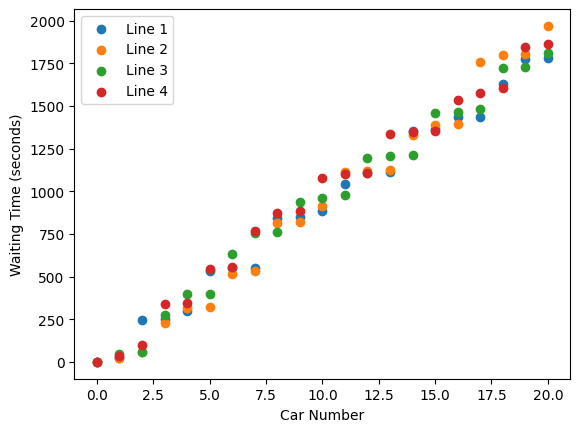

In [3]:
def time_convert(x):
    h, m, s = map(int, x.split(':'))
    return (h * 60 + m) * 60 + s

df = df.map(time_convert)
df = df - df.iloc[0]

for col in df.columns:
    plt.scatter(range(len(df)), df[col], label=col)
plt.xlabel('Car Number')
plt.ylabel('Waiting Time (seconds)')
plt.legend()
plt.show()

Modeling the relationship between $x$ and $y$ as $y=wx$ is appropriate for this problem. There exists a $w \in \mathbb{R}$ that can approximate $y$ reasonably good. By minimizing the cost function
$$ J(w) = \frac{1}{n} \sum_{i=1}^n (wx^{(i)} - y^{(i)})^2
$$
we can find the best $w$.

To ensure the high performance on unseen data, we use first $3$ lines for finding $w$ and the last line for checking the generalization of our model. We call the first and second subset as **training set** and **validation set**, respectively.

In [4]:
x_train = np.concatenate([range(len(df)) for _ in range(3)])
y_train = np.concatenate([df.iloc[:, i] for i in range(3)])

x_val = np.arange(len(df))
y_val = df.iloc[:, -1].values

print('Shapes', x_train.shape, y_train.shape, x_val.shape, y_val.shape)

print(f'Number of training   examples: {len(x_train)}')
print(f'Number of validation examples: {len(x_val)}')

Shapes (63,) (63,) (21,) (21,)
Number of training   examples: 63
Number of validation examples: 21


Use colsed-form normal equation for **Least Squares** to find the best $w$ for the training set.

In [5]:
def closed_form(x, y):
    return np.dot(x, y) / np.dot(x, x)

w = closed_form(x_train, y_train)
print(f'Best value for w: {w:.2f}')

Best value for w: 92.72


Let's plot $J(w)$ for different values of $w$.

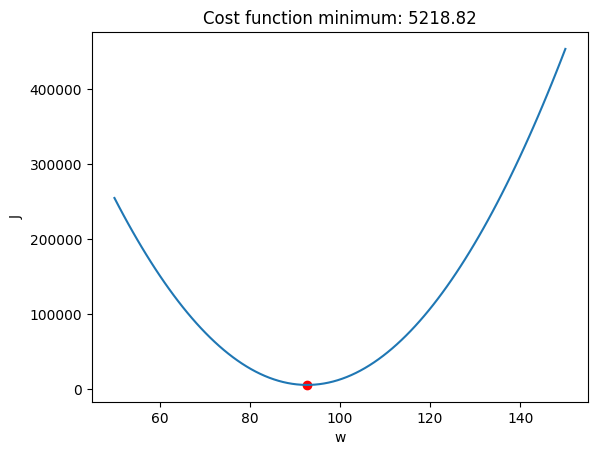

In [6]:
def cost_function(w, x=x_train, y=y_train):
    diff = w * x - y
    n = len(x)
    return np.dot(diff, diff) / n

ws = np.linspace(50, 150, 100)
js = np.array([cost_function(_w) for _w in ws])
j = cost_function(w)

plt.plot(ws, js)
plt.scatter(w, j, c='r')
plt.xlabel('w')
plt.ylabel('J')
plt.title(f'Cost function minimum: {j:.2f}')
plt.show()

A popular metric for linear regression is $R^2$ score. Best possible score is $1$. Use [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) function from scikit-learn to compute this score for training and validation set.

R2 Score, Train: 0.984, Val: 0.983


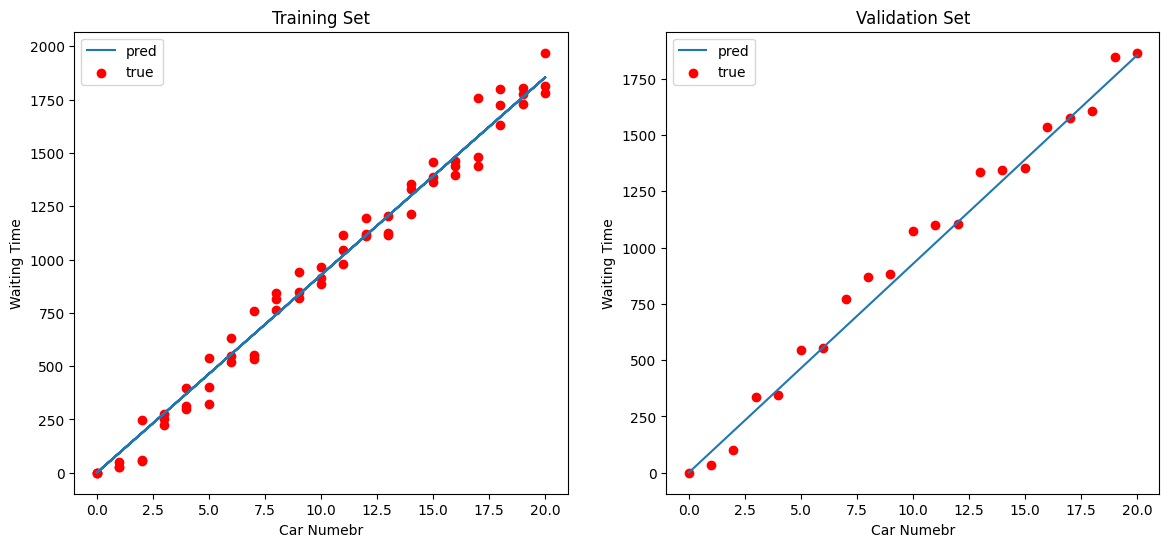

In [7]:
def plot_linear_regression_results(w, x, y_true, ax):
    y_pred = w*x
    r2 = r2_score(y_true, y_pred)
    ax.plot(x, y_pred, label='pred')
    ax.scatter(x, y_true, label='true', c='r')
    ax.set_xlabel('Car Numebr')
    ax.set_ylabel('Waiting Time')
    ax.legend()
    return r2

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

r2_train = plot_linear_regression_results(w, x_train, y_train, axs[0])
axs[0].set_title('Training Set')
r2_val = plot_linear_regression_results(w, x_val, y_val, axs[1])
axs[1].set_title('Validation Set')

print(f'R2 Score, Train: {r2_train:.3f}, Val: {r2_val:.3f}')
plt.show()

Fortunately, our model generalizes very well, since train and val scores are almost equal. Give two reasons why we cannot find a $w$ such that $R^2$ score for **validation set** becomes $1$?

1. Each person in gas station needs an arbitrary amount of petrol and people have different speeds.
2. There are some errors related to time mesurements, about 1 second maybe.

### 1.2- Gradient Descent

Another way of minimizing $J(w)$ is iteratively, taking the derivative of $J$ w.r.t $w$ and step on the opposite direction of $\frac{\partial J(w)}{\partial w}$. This technique is called **Gradient Descent**. There are some *hyperparameters* which we should find appropriate values for them. The most important hyperparameter for this algorithm is *learning rate*. We set it to $0.01$. Also consider *number of iterations* to $10$ for this problem.

Iteration  1, w: 126.72
Iteration  2, w: 80.26
Iteration  3, w: 97.29
Iteration  4, w: 91.05
Iteration  5, w: 93.34
Iteration  6, w: 92.50
Iteration  7, w: 92.81
Iteration  8, w: 92.69
Iteration  9, w: 92.73
Iteration 10, w: 92.72


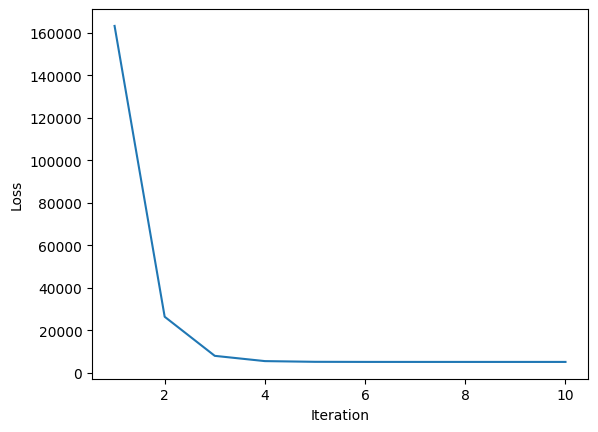

In [8]:
num_iterations = 10
learning_rate = 1e-2
w = 0
losses = []
n = len(x_train)

for iteration in range(1, num_iterations+1):
    diff = w * x_train - y_train
    dw = np.dot(diff, x_train) / n
    w = w - learning_rate * dw
    print(f'Iteration {iteration:2d}, w: {w:.2f}')
    loss = cost_function(w)
    losses.append(loss)

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Unlike closed-form normal equation, gradient descent needs many iterations and hyperparameter tuning. The main reason why gradient descent is used for linear regression is the computational complexity.

What is the order of finding $w$ when using

1. Closed-form normal equation
2. Gradient descent with $T$ iterations

in linear regression? Assume there are $n$ examples in the training set and $x \in \mathbb{R}^k$. Explain your answer. Note that due to these oreders, for large values of $k$, normal equation is computationally expensive.

1. $O(k^2n)$
2. $O(knT)$

## 2- Logistic Regression

Some problems are classification. It means the label $y$ would take on only a small number of discrete values. We first focus on binary classification, then go through multi-class version.

### 2.1- Binary Classification

**Logistic Regression** is a statistical model used for binary classification. It predicts the probability that a given input belongs to a particular class. The key idea is to map the output of a linear model to the range $[0, 1]$ using the **sigmoid function**.

There is a dataset of examples $\mathcal{D} = \{x^{(i)}, y^{(i)}\}_{i=1}^n$ where $x^{(i)} \in \mathbb{R}^2$ and $y^{(i)} \in \{0, 1\}$.

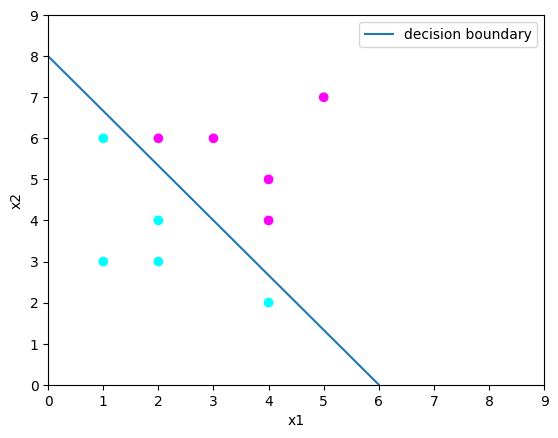

In [9]:
X = np.array([
    [2, 3], [1, 3], [2, 4], [1, 6], [4, 2],
    [4, 5], [5, 7], [3, 6], [4, 4], [2, 6],
])

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.plot([0, 6], [8, 0], label='decision boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.legend()
plt.show()

It turns out that if a point $x =(x_1, x_2)$ is on top of _decision boundary_ line, its label $y$ is $1$, and $0$ otherwise. By having $X$ and $y$, how can we find _decision boundary_?

It turns out that assigning a probability to each example ($\hat{y} \in [0, 1]$), then set all probabilities lower than $0.5$ to $0$ and otherwise $1$ is a more convenient way of solving this problem. One popular function of mapping $(-\infin, +\infin)$ to $(0, 1)$ is **sigmoid function**, usually shown by $\sigma$. The formula is:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

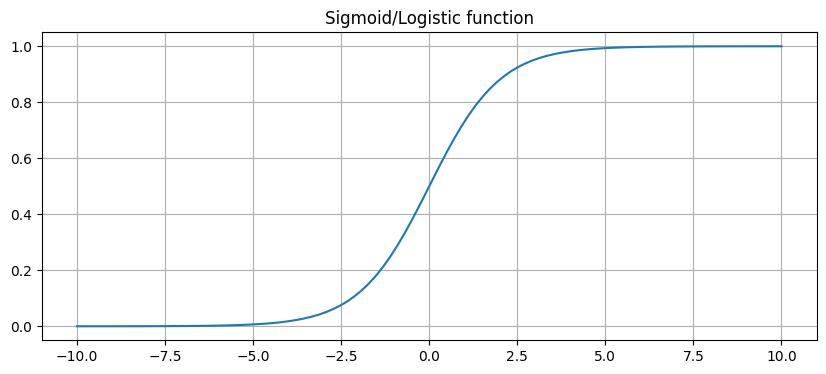

In [10]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))
z = np.linspace(-10, 10, 100)
sigma_z = sigmoid(z)

plt.figure(figsize=(10, 4))
plt.plot(z, sigma_z)
plt.grid()
plt.title('Sigmoid/Logistic function')
plt.show()

Now if we set $z = w^Tx + b$, we reach to Logistic Regression, where $w, b$ are our parameters. The loss function is
$$
J = -\sum_{i} \big(y^{(i)}\log \hat{y}^{(i)} + (1 - y^{(i)})\log(1 - \hat{y}^{(i)}) \big)
$$
for Logistic Regression, where $\hat{y}^{(i)} = \sigma(w^Tx^{(i)} + b)$. By finding loss derivatives w.r.t. $w, b$ use Gradient Descent to update weights and bias:
     $
     w \gets w - \eta \frac{\partial \mathcal{L}}{\partial w}, \quad
     b \gets b - \eta \frac{\partial \mathcal{L}}{\partial b}
     $ Note that unlike Linear Regression, there is **no closed-form solution** available for Logistic Regression.

Iteration  1, w: [0.17930767 0.27886259], b: -5.95
Iteration  2, w: [0.35358578 0.54950783], b: -5.90
Iteration  3, w: [0.49065016 0.76027779], b: -5.86
Iteration  4, w: [0.56050989 0.85689859], b: -5.85
Iteration  5, w: [0.59748268 0.8951884 ], b: -5.84
Iteration  6, w: [0.62113056 0.91025468], b: -5.84
Iteration  7, w: [0.63859065 0.91501405], b: -5.84
Iteration  8, w: [0.65285451 0.91484718], b: -5.84
Iteration  9, w: [0.66532816 0.91226323], b: -5.84
Iteration 10, w: [0.67671658 0.90850803], b: -5.85


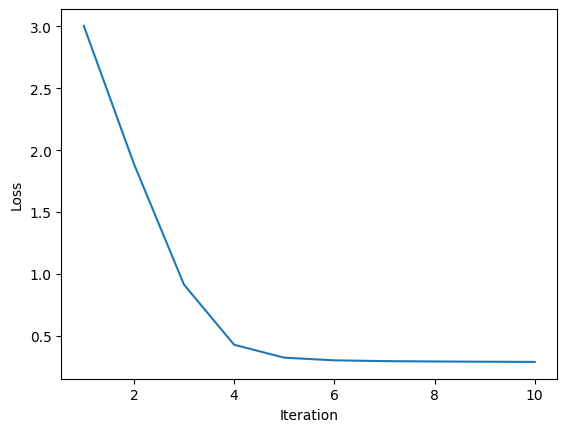

In [11]:
y = y.reshape(-1, 1)
w = np.zeros((2, 1))
b = np.array([-6.])
learning_rate = 0.01
num_iterations = 10
losses = []
for iteration in range(1, 1+num_iterations):
    y_hat = sigmoid((X @ w) + b)
    loss = -np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))
    losses.append(loss)
    diff = y_hat - y
    b -= learning_rate * np.sum(diff)
    w -= learning_rate * (X.T @ diff)
    print(f'Iteration {iteration:2d}, w: {w.squeeze()}, b: {b[0]:.2f}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

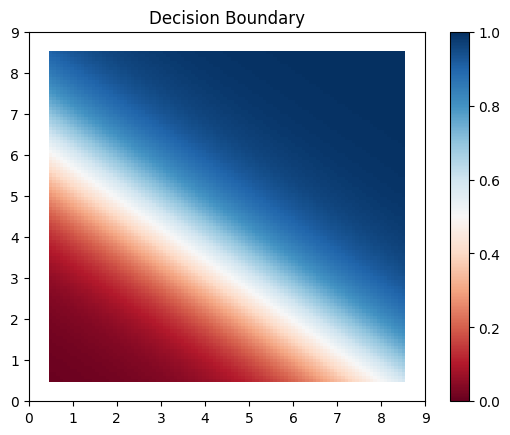

In [13]:
resolution = 100
x1, x2 = np.meshgrid(np.linspace(.5, 8.5, resolution), np.linspace(.5, 8.5, resolution))

X_test = np.hstack([x1.reshape(-1, 1), x2.reshape(-1, 1)])
y_pred = sigmoid((X_test @ w) + b)
y_pred = y_pred.reshape(resolution, resolution)

fig, ax = plt.subplots()

c = ax.pcolormesh(x1, x2, y_pred, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('Decision Boundary')
ax.axis([0, 9, 0, 9])
fig.colorbar(c, ax=ax)

plt.show()

Now, consider a dataset which is not linearly seperable.

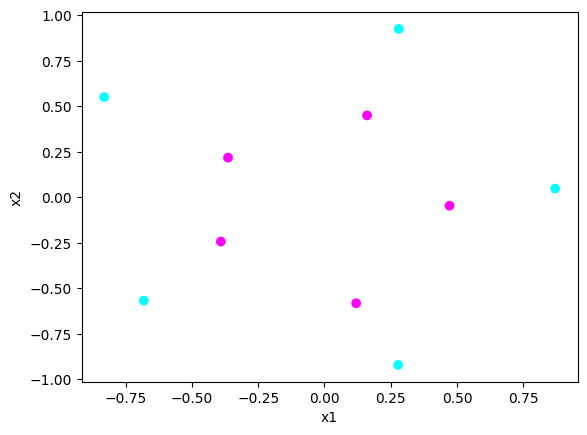

In [14]:
X, y = make_circles(n_samples=10, factor=0.5, noise=0.05, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Show that by logistic regression we cannot find decision boundary for this dataset. (*Hint: points where $\hat{y} = 0.5$ is called decision boundary.*)

We come back to this problem later on.

We know that Logistic Regression decision boundary (points where $\hat{y} = 0.5$) is linear:

$$
\frac{1}{1 + e^{-(w^Tx + b)}} = \frac{1}{2} \Rightarrow
w^Tx + b = 0
$$

### 2.2- Softmax Regression

This block generates synthetic data using `make_blobs` with a specified number of classes and plots the data to visualize the distribution of points across different classes.

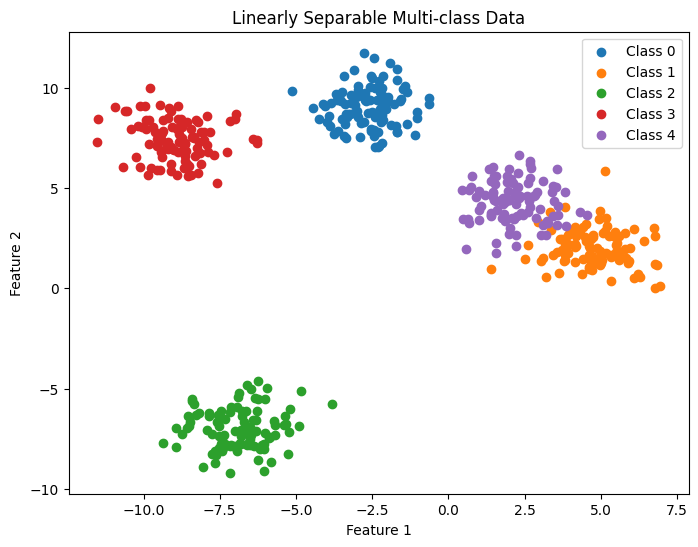

In [15]:
num_classes = 5
random_state = 42
X, y = make_blobs(n_samples=500, centers=num_classes, n_features=2, cluster_std=1.0, random_state=random_state)

plt.figure(figsize=(8, 6))
for i in np.unique(y):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=f"Class {i}")
plt.title("Linearly Separable Multi-class Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The dataset splits into training and testing subsets using `train_test_split`. This ensures the model is evaluated on unseen data.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Softmax is the $C$-class version for sigmoid. The output is a probability vector with dimension $C$ which assigns a probability to each element based on their magnitude. This is why it's called **softmax**.
$$
\text{softmax}(z)_i = \frac{\exp(z_i)}{\sum_{c=1}^C \exp(z_c)}
$$

The cross entropy loss $\mathcal{L}_{\text{ce}}$ for $N$ examples in $C$-class prediction is defined as follows:
$$
\mathcal{L}_{\text{ce}} = -\frac{1}{N}\sum_{n=1}^N \big[ \sum_{c=1}^C y_c \log \text{softmax}(z)_c \big]
$$

In [17]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-7
    return -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))

We model softmax's input as $z=x^TW+b$, where $W \in \mathbb{R}^{D \times C}$ and $b \in \mathbb{R}^{1\times C}$ are our parameters. $D$ is the number of features. Initialize the parameters and create one-hot encoding for the training lables.

In [18]:
y_train_one_hot = np.eye(num_classes)[y_train]

W = np.random.randn(2, num_classes) * 0.01
b = np.zeros((1, num_classes))

Train the model with gradient descent and print the loss for every 10 epochs. We recommend calculate the derivative w.r.t $z$ s (`dZ`), then use it for `dW` and `db`.

In [19]:
lr = 0.1
epochs = 1000
for epoch in range(epochs):
    Z = np.dot(X_train, W) + b
    y_pred = softmax(Z)

    loss = cross_entropy_loss(y_train_one_hot, y_pred)

    dZ = y_pred - y_train_one_hot
    dW = np.dot(X_train.T, dZ) / len(X_train)
    db = np.sum(dZ, axis=0, keepdims=True) / len(X_train)

    W -= lr * dW
    b -= lr * db

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")


Epoch 100/1000, Loss: 0.1644
Epoch 200/1000, Loss: 0.1165
Epoch 300/1000, Loss: 0.0969
Epoch 400/1000, Loss: 0.0861
Epoch 500/1000, Loss: 0.0792
Epoch 600/1000, Loss: 0.0744
Epoch 700/1000, Loss: 0.0708
Epoch 800/1000, Loss: 0.0681
Epoch 900/1000, Loss: 0.0659
Epoch 1000/1000, Loss: 0.0641


Now, it's time for testing performance on test set.

In [20]:
Z_test = np.dot(X_test, W) + b
y_test_pred = np.argmax(softmax(Z_test), axis=1)  # Predicted classes
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 98.67%


The following cell will plot decision boundary.

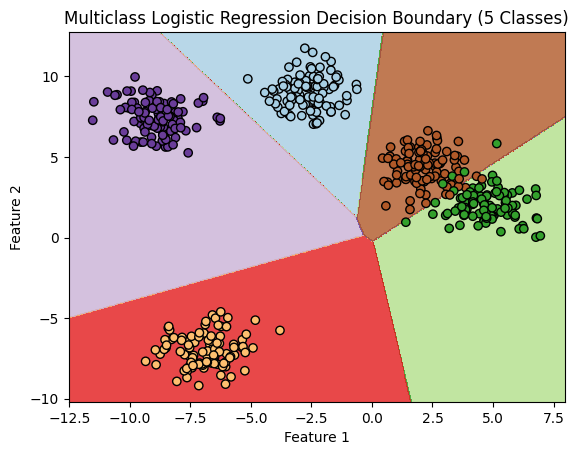

In [21]:
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = np.dot(grid, W) + b
pred_grid = np.argmax(softmax(Z), axis=1).reshape(xx.shape)

plt.contourf(xx, yy, pred_grid, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.title(f"Multiclass Logistic Regression Decision Boundary ({num_classes} Classes)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## 3. Neural Network

Neural Networks consist of several layers, each layer has several small computational units called **neurons**. Each neuron is very simple and weak to find complex patterns, but by setting these small neurons together, we can make super strong models! Let's go deeper.

### 3.1- Two Layer Neural Network

Logistic Regression is the simplest Neural Network, one layer and one neuron. Each neuron first do a linear operation on its input, then feeds the result to an activation function. We can first find some features from inputs, then feed those valuable features to the logistic model.

A **two-layer** neural network consists of:
1. **inputs**: features from the dataset. We don't count this as a layer
2. **hidden layer**: extracting valuable features.
3. **output layer**: final predictions.

By using this two-layer neural netwrok, we can achieve non-linear classification.

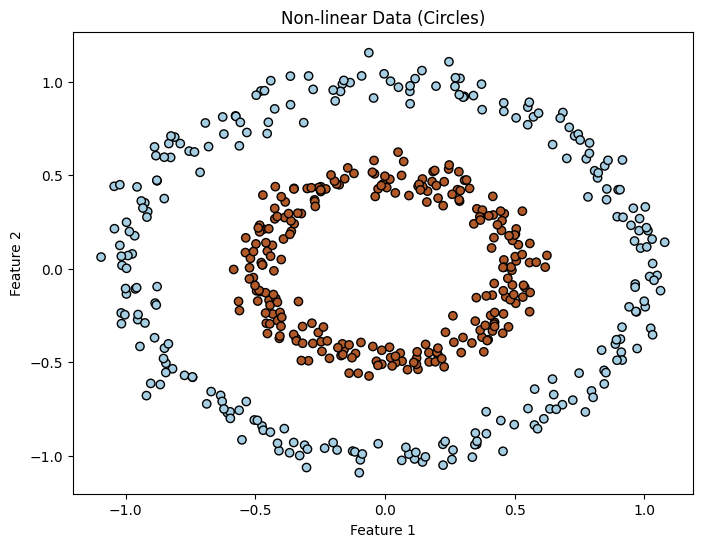

In [22]:
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
plt.title("Non-linear Data (Circles)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

The details of the architecture are as follows:

- **Inputs:** For $N$ samples each with dimension $M$, the input matrix is $X \in \mathbb{R}^{N\times M}$
- **Hidden Layer:** Computes the linear transformation $Z_1$ with $W_1$ and $b_1$, followed by a non-linear activation $A_1$. The bias $b_1 \in \mathbb{R}^{1\times H}$ and the weights $W_1 \in \mathbb{R}^{M\times H}$ are the parameters of this layer, and $H$ is the hidden dimension.
Here $W_1, b_1, W_2, b_2$ are the model parameters and should be optimized.
- **Output Layer:** Very similar to *Hidden Layer* with parameters $W_2 \in \mathbb{R}^{H \times O}, b_2 \in \mathbb{R}^{1, O}$. Because we want to use this model for binary classification, we have $O=1$.

So, the **forward pass** would be:
$$
\begin{align}
Z_1 &= XW_1 + b_1 \\
A_1 &= \text{ReLU}(Z_1) \\
Z_2 &= A_1W_2 + b_2 \\
A_2 &= \sigma(Z_2)
\end{align}
$$
, where $\sigma(.)$ is the sigmoid function, which you are familiar with, and $\text{ReLU}(.)$ applies $\max(x, 0)$ for every value of its input. The bias term $b_1$ [broadcasts](https://numpy.org/doc/stable/user/basics.broadcasting.html) to act like stacking $b_1$ for $N$ times, $B_1 \in \mathbb{R}^{N \times H}$. Same for $b_2$.

We use the same **loss function** for binary classification.
$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log({A_2}_i) + (1 - y_i) \log(1 - {A_2}_i) \right]
$$


In [23]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-7
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

Prove mathematically that for input $x \in \mathbb{R}^{M}$ if we remove the non-linear activation function $\text{ReLU}$, i.e. $A_1=Z_1$, the resulting model has the same strength as logistic regression. In other words there exists $W' \in \mathbb{R}^{M \times O}, b' \in \mathbb{R}^{1 \times O}$ for every $W_1, b_1, W_2, b_2$ such that $Z_2 = x^TW' + b'$.

By removing the inner activation function, we have:
$$
Z_2 = (x^TW_1 + b_1)W_2 + b_2 = x^TW_1W_2 + b_1W_2 + b_2
$$

So $W' = W_1W_2$ and $b' = b_1W_2 + b_2$.

### 3-2. Backpropagation

To minimize the loss, we compute gradients of $\mathcal{L}$ w.r.t weights and biases using the chain rule. We suggest to use `dW1` notation in code for $\frac{\partial \mathcal{L}}{\partial W_1}$.

We use **Gradient Descent** to update the weights and biases:
$$
\begin{align}
W_1 \gets W_1 - \eta dW_1,& \quad b_1 \gets b_1 - \eta db_1 \\
W_2 \gets W_2 - \eta dW_2,& \quad b_2 \gets b_2 - \eta db_2 \\
\end{align}
$$
where $ \eta $ is the learning rate. This process is called **backpropagation**.

In [24]:
def backward_pass(X, y, Z1, A1, Z2, A2, W2):
    m = X.shape[0]

    dZ2 = A2 - y.reshape(-1, 1)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

It's time for training. First initialize the parameters randomly. Then for each epoch:

- Perform forward pass to compute $ A_2 $.
- Compute the loss.
- Perform backward pass to compute gradients.
- Update parameters using Gradient Descent.

In [25]:
input_dim = 2
hidden_dim = 3
output_dim = 1

W1 = np.random.randn(input_dim, hidden_dim) * 0.01
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * 0.01
b2 = np.zeros((1, output_dim))

epochs = 30000
learning_rate = 0.1

for epoch in range(epochs):
    Z1, A1, Z2, A2 = forward_pass(X_train, W1, b1, W2, b2)

    loss = binary_cross_entropy(y_train, A2)

    dW1, db1, dW2, db2 = backward_pass(X_train, y_train, Z1, A1, Z2, A2, W2)

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if (epoch+1) % (epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

Epoch 3000/30000, Loss: 1.1847
Epoch 6000/30000, Loss: 2.5415
Epoch 9000/30000, Loss: 3.2078
Epoch 12000/30000, Loss: 3.6266
Epoch 15000/30000, Loss: 3.9542
Epoch 18000/30000, Loss: 4.2129
Epoch 21000/30000, Loss: 4.4262
Epoch 24000/30000, Loss: 4.6063
Epoch 27000/30000, Loss: 4.7609
Epoch 30000/30000, Loss: 4.8954


To check the generalization of our model, we calculate the accuracy on the test set.

In [26]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(X, W1, b1, W2, b2)
    return (A2 >= 0.5).astype(int)

y_pred = predict(X_test, W1, b1, W2, b2)
accuracy = np.mean(y_pred.flatten() == y_test) * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 100.00%


The bellow cell shows the non-linear decision boundary that we learned.

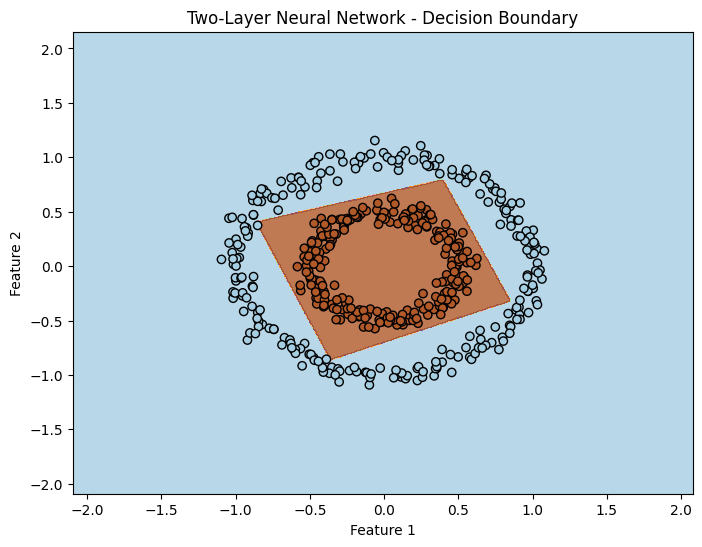

In [27]:
def plot_decision_boundary(X, y, W1, b1, W2, b2, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(grid, W1, b1, W2, b2)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(X, y, W1, b1, W2, b2, "Two-Layer Neural Network - Decision Boundary")

### 3-3. RNN

A Recurrent Neural Network (RNN) is a type of neural network designed to process sequential data by incorporating feedback connections. Unlike traditional feedforward neural networks, RNNs can retain information from previous inputs through a hidden state, making them well-suited for tasks like time-series analysis, natural language processing, and sequence modeling.

RNNs operate by applying the same set of weights at every time step, allowing them to model dependencies over time. This capability is essential for tasks where context or order matters, such as predicting the next word in a sentence or analyzing stock prices. There are many types of RNN architecture.

1. **One-to-One**  
   This is the standard neural network architecture, where each input maps to a single output.  
   - **Example**: *Image classification*.  
     An image is passed as input, and the output is the class label of the object in the image. For instance, given an image of a dog, the network outputs the label "dog."

   <div align="center">
       <img src="https://github.com/fraxea/Linear-Algebra-FALL2024-Assignment-2/blob/main/Neural%20Network%20Intro/images/rnn-one-to-one.png?raw=1" alt="One-to-One RNN" width="300">
   </div>

2. **One-to-Many**
   This architecture takes a single input and produces a sequence of outputs.  
   - **Example**: *Music generation*.  
     A single starting note or chord is provided as input, and the network generates a sequence of notes to form a melody or song.
   - **Example**: *Image captioning*.  
     An image is provided as input, and the network generates a sequence of words to describe the image, such as "A cat sitting on a mat."
   <div align="center">
       <img src="https://github.com/fraxea/Linear-Algebra-FALL2024-Assignment-2/blob/main/Neural%20Network%20Intro/images/rnn-one-to-many.png?raw=1" alt="One-to-Many RNN" width="300">
   </div>

3. **Many-to-One**  
   This architecture processes a sequence of inputs and produces a single output.  
   - **Example**: *Sentiment analysis*.  
     A sentence, such as "The movie was absolutely thrilling," is provided as input, and the network outputs the sentiment, such as "positive."

   <div align="center">
       <img src="https://github.com/fraxea/Linear-Algebra-FALL2024-Assignment-2/blob/main/Neural%20Network%20Intro/images/rnn-many-to-one.png?raw=1" alt="Many-to-One RNN" width="300">
   </div>

4. **Many-to-Many (Same Length)**  
   In this architecture, a sequence of inputs generates a sequence of outputs, with each output corresponding to a specific input, and the lengths of input and output sequences are the same.  
   - **Example**: *Video frame labeling*.  
     Each frame of a video sequence is processed to predict corresponding labels, such as "walking," "running," or "jumping" for individual video frames.

   <div align="center">
       <img src="https://github.com/fraxea/Linear-Algebra-FALL2024-Assignment-2/blob/main/Neural%20Network%20Intro/images/rnn-many-to-many-async.png?raw=1" alt="Many-to-Many Variable Length RNN" width="300">
   </div>

5. **Many-to-Many (Variable Length)**  
   In this architecture, a sequence of inputs generates a sequence of outputs, but the lengths of the input and output sequences may differ.  
   - **Example**: *Machine translation*.  
     A sentence in one language, such as "What is your name?", is provided as input, and the network generates the translated sentence in another language, such as "¿Cómo te llamas?" in Spanish.

   <div align="center">
       <img src="https://github.com/fraxea/Linear-Algebra-FALL2024-Assignment-2/blob/main/Neural%20Network%20Intro/images/rnn-many-to-many-sync.png?raw=1" alt="Many-to-Many Same Length RNN" width="300">
   </div>

We will use the last case _Many-to-Many (Variable Length)_ later.

In an RNN, the input is typically processed sequentially over discrete time steps. At each time step $t$, the RNN receives:
- $x_t$: the input at the current time step.
- $h_{t-1}$: the hidden state from the previous time step.

The RNN updates its hidden state $h_t$ based on $x_t$ and $h_{t-1}$ using a shared set of weights across all time steps. This mechanism allows the network to "remember" past information while processing new inputs.

$h_t = \sigma(W_h \cdot x_t + U_h \cdot h_{t-1} + b_h)$

$y_t = \text{softmax}(W_y \cdot h_t + b_y)$

Where:
- $W_h, U_h, b_h$: Weights and biases for the hidden state.
- $W_y, b_y$: Weights and biases for the output.
- $\sigma$: Activation function (e.g., tanh or ReLU).

For this type of RNN, we could say there are two parts:

- **Encoder**: Processes the input sequence $\{x_1, x_2, ..., x_t\}$, updating its hidden state at each step.
- **Decoder**: Generates outputs $\{y_1, y_2, ..., y_{t'}\}$ from the encoder's final hidden state.

So the **forward pass** steps are:

1. **Initialize hidden states.**
2. **Iterate through the input sequence.**
3. **Use hidden states and inputs to compute outputs via activation functions.**

In an RNN, the gradients are computed recursively at each time step. The chain rule is applied multiple times to compute the gradient with respect to the parameters.

$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial h} \cdot \frac{\partial h}{\partial W}$
    </div>
    
Where:

- $L$ is the loss function.
- $W$ represents the model parameters (weights).
- $y$ is the output of the network.
- $h$ is the hidden state.

At each time step, we need to compute the derivative of the loss with respect to the weights and propagate the gradients backward through the hidden states.

In [28]:
class RNN:
    def __init__(self, vocab_size, hidden_size=100, seq_length=25, learning_rate=0.1):
        """
        Initializes the RNN model with the given parameters.

        Arguments:
        vocab_size -- The number of unique characters in the vocabulary.
        hidden_size -- The size of the hidden state vector (default 100).
        seq_length -- The length of input sequences to process at a time (default 25).
        learning_rate -- The learning rate for gradient updates (default 0.1).
        """
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))

        self.memory = {
            "Wxh": np.zeros_like(self.Wxh),
            "Whh": np.zeros_like(self.Whh),
            "Why": np.zeros_like(self.Why),
            "bh": np.zeros_like(self.bh),
            "by": np.zeros_like(self.by)
        }

    def rnn_forward(self, inputs, h_prev):
        """
        Performs the forward pass of the RNN for a sequence of inputs.

        Arguments:
        inputs -- List of indices representing the input sequence (each index corresponds to a character).
        h_prev -- The previous hidden state (for the first step, it's the initial hidden state, usually zeros).

        Returns:
        x -- A dictionary with the input one-hot vectors for each time step.
        h -- A dictionary with the hidden states for each time step.
        """
        x, h = {}, {}
        h[-1] = np.copy(h_prev)  # Initial hidden state

        # Loop over the sequence of inputs and compute the hidden states
        for t in range(len(inputs)):
            # One-hot vector for the input at time step t
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][inputs[t]] = 1
            # Update hidden state
            h[t] = np.tanh(np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t - 1]) + self.bh)

        return x, h

    def compute_cross_entropy_loss(self, y, targets):
        """
        Computes the cross-entropy loss between the predicted output and the target.

        Arguments:
        y -- The predicted output from the network (before softmax).
        targets -- The true target label (index of the correct character).

        Returns:
        loss -- The computed cross-entropy loss.
        p -- The probabilities of each character in the output (softmax).
        """
        p = np.exp(y) / np.sum(np.exp(y))
        loss = -np.log(p[targets, 0])
        return loss, p

    def rnn_backward(self, inputs, targets, activations, h_prev):
        """
        Performs the backward pass through time, computing gradients for all parameters.

        Arguments:
        inputs -- The input sequence as indices (each index corresponds to a character).
        targets -- The target sequence (next character in the sequence).
        activations -- The activations from the forward pass (inputs, hidden states, outputs, and probabilities).
        h_prev -- The previous hidden state (for the first time step).

        Returns:
        gradients -- A dictionary with gradients for all parameters (weights and biases).
        """
        gradients = {param: np.zeros_like(getattr(self, param)) for param in ["Wxh", "Whh", "Why", "bh", "by"]}
        dh_next = np.zeros_like(h_prev)

        # Loop over the sequence in reverse order (backpropagation through time)
        for t in reversed(range(len(inputs))):
            # Gradient for Wy and by with the help of the softmax probabilities
            dy = np.copy(activations["p"][t])
            dy[targets[t]] -= 1
            gradients["Why"] += np.dot(dy, activations["h"][t].T)
            gradients["by"] += dy

            # Gradient for Whh, Wxh, and bh using the chain rule
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = (1 - activations["h"][t] * activations["h"][t]) * dh
            gradients["bh"] += dh_raw
            gradients["Wxh"] += np.dot(dh_raw, activations["x"][t].T)
            gradients["Whh"] += np.dot(dh_raw, activations["h"][t - 1].T)
            dh_next = np.dot(self.Whh.T, dh_raw)

        # Clip gradients to prevent exploding gradients
        for key in gradients:
            np.clip(gradients[key], -5, 5, out=gradients[key])

        return gradients

    def forward(self, inputs, targets, h_prev):
        """
        Performs the forward pass of the RNN, computing the loss and storing activations.

        Arguments:
        inputs -- The input sequence (list of indices corresponding to characters).
        targets -- The target sequence (next character in the sequence).
        h_prev -- The previous hidden state (usually zeros at the start).

        Returns:
        loss -- The total loss for the sequence.
        activations -- A dictionary containing the inputs, hidden states, outputs, and probabilities.
        h_final -- The final hidden state after processing the entire sequence.
        """
        x, h = self.rnn_forward(inputs, h_prev)  # Get the input activations and hidden states
        y = {}  # Dictionary for output activations
        p = {}  # Dictionary for softmax probabilities
        loss = 0  # Initialize the total loss

        # Loop over each time step to calculate output and loss
        for t in range(len(inputs)):
            y[t] = np.dot(self.Why, h[t]) + self.by
            loss_t, p[t] = self.compute_cross_entropy_loss(y[t], targets[t])
            loss += loss_t

        activations = {"x": x, "h": h, "y": y, "p": p}
        return loss, activations, h[len(inputs) - 1]

    def backward(self, inputs, targets, activations, h_prev):
        """
        Performs the backward pass and calculates the gradients for all parameters.

        Arguments:
        inputs -- The input sequence as indices.
        targets -- The target sequence (next character in the sequence).
        activations -- The activations obtained from the forward pass.
        h_prev -- The previous hidden state.

        Returns:
        gradients -- The gradients for all parameters (weights and biases).
        """
        return self.rnn_backward(inputs, targets, activations, h_prev)

    def update_parameters(self, gradients):
        """
        Updates the model parameters using Adagrad (adaptive gradient descent).

        Arguments:
        gradients -- The gradients computed during the backward pass.
        """
        for param in ["Wxh", "Whh", "Why", "bh", "by"]:
            mem = self.memory[param]  # Memory for each parameter (stores squared gradients)
            grad = gradients[param]  # Gradient for the parameter
            mem += grad * grad  # Update the memory with the squared gradient
            getattr(self, param)[:] += -self.learning_rate * grad / np.sqrt(mem + 1e-8)

    def sample(self, h, seed_idx, length, idx_to_char):
        """
        Generates a sequence of characters starting from a seed index and hidden state.

        Arguments:
        h -- The initial hidden state.
        seed_idx -- The index of the starting character.
        length -- The number of characters to generate.
        idx_to_char -- A dictionary mapping indices to characters.

        Returns:
        generated_sequence -- A string containing the generated characters.
        """
        x = np.zeros((self.vocab_size, 1))  # One-hot vector for the seed character
        x[seed_idx] = 1  # Set the input value to the seed index
        indices = []  # List to store the generated character indices

        # Generate the sequence character by character
        for _ in range(length):
            # Softmax probabilities
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            # Sample the next character and add it to the sequence
            idx = np.random.choice(range(self.vocab_size), p=p.flatten())
            indices.append(idx)
            # Update the input vector for the next character
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

        generated_sequence = ''.join([idx_to_char[idx] for idx in indices])
        return generated_sequence


Run the bellow code to check your implementation.

In [29]:
def forward_check(model: RNN):
    np.random.seed(42)
    model.Why = np.random.randn(model.vocab_size, model.hidden_size) * 0.01
    model.by = np.zeros((model.vocab_size, 1))
    model.Whh = np.random.randn(model.hidden_size, model.hidden_size) * 0.01
    model.bh = np.zeros((model.hidden_size, 1))
    model.Wxh = np.random.randn(model.hidden_size, model.vocab_size) * 0.01

    inputs = [0, 1, 2, 3, 4]
    targets = [1, 2, 3, 4, 5]
    h_prev = np.zeros((model.hidden_size, 1))

    loss, activations, h_prev = model.forward(inputs, targets, h_prev)
    true_activations = {'x': { 0: [1.,0.,0.,0.,0.,0.,0.,0.,0.,0.], 1: [0.,1.,0.,0.,0.,0.,0.,0.,0.,0.], 2: [0.,0.,1.,0.,0.,0.,0.,0.,0.,0.], 3: [0.,0.,0.,1.,0.,0.,0.,0.,0.,0.], 4: [0.,0.,0.,0.,1.,0.,0.,0.,0.,0.]},\
        'h': {-1: [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.], 0: [0.00357786,0.00570884,0.02314245,-0.00730354,-0.00792504,-0.01260817,-0.00926904,0.01441174,0.00113517,-0.00208122],1: [0.00532906,0.01092843,-0.01856798,0.00177107,-0.00164517,0.00896778,-0.00017545,-0.01445634,0.00620685,-0.00469031],2: [0.01078794,0.00970189,0.00682015,0.00089649,0.00578389,0.0211546,-0.03283082,0.01123043,0.01610173,-0.00581735],3: [9.83594060e-03,6.40353265e-03,-1.52415013e-02,-6.04649008e-03,9.20566592e-03,9.41719541e-03,-1.01101498e-02,7.41256026e-05,-1.25355255e-02,9.00896163e-03],4: [-0.01404753,-0.00356341,-0.00452658,0.02134874,-0.01147959,-0.01507622,-0.0026894,-0.00958204,0.0214362,0.00365519]},
        'y': {0: [4.42131434e-05,5.18413247e-04,3.48474703e-04,-7.38752434e-05,4.75004315e-04,-3.94161656e-04,-2.62968193e-04,7.34047238e-05,4.65570116e-04,1.50942954e-04],1:[-2.67374404e-04,-2.10222593e-04,-4.13291632e-05,2.22376208e-04,-1.40008804e-05,1.99242798e-04,1.54427123e-04,4.80502421e-04,-3.94055775e-04,8.38526470e-05],2:[-5.04514097e-04,-1.07819208e-05,4.60349063e-04,-6.20262241e-04,2.75749785e-04,4.50943117e-04,4.10120810e-04,2.90376993e-04,-4.24583026e-04,-3.32079921e-04],3:[-2.45770917e-04,-1.19115545e-04,3.31549672e-04,2.47852018e-04,-2.39006535e-04,3.86994625e-04,2.89021373e-04,-3.18459330e-04,-2.93990266e-04,-2.70463085e-05],4: [9.63462241e-05,-3.04074534e-04,-6.03755501e-04,-2.12401835e-04,2.96745514e-05,2.95335699e-05,-4.69393914e-04,3.80234458e-04,-1.41870833e-04,1.38871866e-04]},
        'p': {0: [0.09999097,0.10003839,0.1000214,0.09997916,0.10003405,0.09994714,0.09996026,0.09999389,0.10003311,0.10000164],1: [0.09997113,0.09997684,0.09999373,0.1000201,0.09999646,0.10001779,0.10001331,0.10004592,0.09995847,0.10000625],2:[0.0999496,0.09999896,0.10004608,0.09993803,0.10002762,0.10004514,0.10004106,0.10002908,0.09995759,0.09996684],3:[0.0999753,0.09998797,0.10003304,0.10002466,0.09997598,0.10003858,0.10002878,0.09996804,0.09997048,0.09999717],4:[0.1000202,0.09998016,0.0999502,0.09998932,0.10001353,0.10001352,0.09996363,0.1000486,0.09999638,0.10002445]}
    }
    h_true = [-0.01404753, -0.00356341, -0.00452658,  0.02134874, -0.01147959, -0.01507622, -0.0026894  ,-0.00958204  ,0.0214362   ,0.00365519]

    assert np.allclose(loss, 11.5133, atol=1e-4), f"Loss is wrong"
    assert np.allclose(h_prev, np.array(h_true).reshape(-1, 1), atol=1e-4), f"h_prev is wrong"
    for key in true_activations:
        for i in true_activations[key]:
            assert np.allclose(activations[key][i], np.array(true_activations[key][i]).reshape(-1, 1), atol=1e-4), f"{key}[{i}] is wrong"
    print('\033[92m', "Forward check passed!", '\033[0m')

def backward_check(model: RNN):
    np.random.seed(42)
    model.Why = np.random.randn(model.vocab_size, model.hidden_size) * 0.01
    model.by = np.zeros((model.vocab_size, 1))
    model.Whh = np.random.randn(model.hidden_size, model.hidden_size) * 0.01
    model.bh = np.zeros((model.hidden_size, 1))
    model.Wxh = np.random.randn(model.hidden_size, model.vocab_size) * 0.01

    inputs = [0, 1, 2, 3, 4]
    targets = [1, 2, 3, 4, 5]
    h_prev = np.zeros((model.hidden_size, 1))

    loss, activations, h_prev = model.forward(inputs, targets, h_prev)
    gradients = model.backward(inputs, targets, activations, h_prev)

    true_gradients = {
        'Wxh': [0.006174284605410949, -0.012949113935067409, 0.007774958223286806, -0.00574674273481456, -0.0015210712857363304],
        'Whh': [-8.185355189117637e-05, -5.445083893314215e-05, -0.0004600497994120127, 0.00011238956058036343, 4.259012913132207e-05],
        'Why': [0.001547070623019326, 0.0029168422034269864, -0.000837077245075439, 0.0010671778802844893, -0.0006066559800196766],
        'bh': [-0.006267685126920544, 0.007693535302362807, 0.00441014575869402, 0.025637605727660873, -0.006572873490752374],
        'by': [0.49990719921138854, -0.5000176785417658, -0.4999555533183204, -0.5000487172534959, -0.4999523575590996],
    }

    for key in true_gradients:
        assert np.allclose(gradients[key].flatten()[:5], np.array(true_gradients[key]), atol=1e-4), f"{key} is wrong"
    print('\033[92m', "Backward check passed!", '\033[0m')

model = RNN(vocab_size=10, hidden_size=10, seq_length=10, learning_rate=0.1)
forward_check(model)
backward_check(model)

 Forward check passed! 
 Backward check passed! 


## 4- Harry Potter Generation

In this section, we will train a Recurrent Neural Network (RNN) model to generate text based on the "Harry Potter" dataset. The model will learn to generate characters of text one by one, with each character's prediction dependent on the previous ones. This task demonstrates how RNNs can be used for sequence generation, which is particularly useful for text generation tasks like creating new chapters or dialogues in the style of a given corpus.

### 4.1- Dataset

The dataset is crucial for training our RNN. In this case, we are using the preprocessed text of all the Harry Potter books. The data is read from a file, and we then map every unique character to an index and vice versa. This mapping allows us to easily convert characters into numerical data, which can be fed into the RNN.

  **Explanation**:
- We first load the data and create a vocabulary consisting of unique characters.
- We then map each character to a unique index (`char_to_idx`) and create a reverse mapping (`idx_to_char`) to generate characters back from their indices during generation.
- The preprocessed data is used to train the RNN model.


In [30]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    vocab = list(set(data))
    char_to_idx = {ch: i for i, ch in enumerate(vocab)}
    idx_to_char = {i: ch for i, ch in enumerate(vocab)}
    return data, vocab, char_to_idx, idx_to_char

data, vocab, char_to_idx, idx_to_char = load_data('Harry_Potter_all_books_preprocessed.txt')

### 4.2- Train

Training an RNN for text generation involves feeding sequences of characters from the dataset into the model, allowing it to learn the patterns of character sequences and predict the next character in the sequence. The goal of training is to minimize the loss function, which measures how well the model predicts the next character.


In this case, we are using a simple RNN model, and we will train it using the following process:

1. **Data Preprocessing**:
   We randomly select a sequence of characters from the dataset (a mini-batch) to use as input for the model. The input is a sequence of characters, and the target is the next character in the sequence, i.e., the character that follows the given input in the dataset.

2. **Forward Pass**:
   The input characters are converted to indices using the `char_to_idx` mapping. These indices are then fed into the RNN, which generates predictions for the next character in the sequence. The loss is computed by comparing the predicted characters with the actual target characters.

3. **Backward Pass**:
   After computing the loss, the gradients are calculated using backpropagation. These gradients tell us how to adjust the model’s parameters (weights and biases) to reduce the loss in future iterations.

4. **Parameter Update**:
   Using the computed gradients, the model’s parameters are updated. This update is done via gradient descent (or a similar optimization method), which moves the model's parameters in the direction that reduces the loss.

5. **Repeat**:
   The above steps are repeated for a set number of iterations (or epochs), and the loss is tracked to monitor the model’s performance.

During training, the loss is computed at regular intervals (every 100 iterations), allowing us to monitor the model’s progress and ensure that it is learning effectively.

By the end of the training, the RNN should generate text resembling the Harry Potter books' style. It can produce new, similar text from a seed sequence. However, due to the RNN's simplicity, the generated text may lack coherence, structure, and logical flow, especially over longer sequences. While the model can still generate creative text, it may not fully capture the depth of the original writing.


In [31]:
def train_rnn(model, data, char_to_idx, iterations=10000):
    """
    Trains the SimpleRNN model using the provided data and updates the model's parameters.

    Arguments:
    model -- The SimpleRNN model to train.
    data -- The input text data as a string.
    char_to_idx -- A dictionary mapping characters to indices.
    iterations -- The number of iterations to train the model (default 10000).

    Returns:
    loss_history -- A list of loss values at each iteration for tracking progress.
    """
    h_prev = np.zeros((model.hidden_size, 1))  # Initialize the hidden state (zero at the start)
    loss_history = []  # List to store the loss history for visualization

    # Training loop
    for iteration in range(iterations):
        # Generate random indices for a mini-batch of training data
        start_idx = np.random.randint(0, len(data) - model.seq_length)  # Random start index
        end_idx = start_idx + model.seq_length  # Calculate the end index
        inputs = [char_to_idx[ch] for ch in data[start_idx:end_idx]]  # Convert characters to indices
        targets = [char_to_idx[ch] for ch in
                   data[start_idx + 1:end_idx + 1]]  # The next character in the sequence is the target

        # Perform the forward pass and calculate the loss
        loss, activations, h_prev = model.forward(inputs, targets, h_prev)

        # Perform the backward pass and compute the gradients
        gradients = model.backward(inputs, targets, activations, h_prev)

        # Update the model parameters using the computed gradients
        model.update_parameters(gradients)

        # Store and print the loss for every 100 iterations
        if iteration % 100 == 0:
            loss_history.append(loss)
            print(f"Iteration {iteration}, Loss: {loss}")

    return loss_history

rnn_model = RNN(len(vocab))
loss_history = train_rnn(rnn_model, data, char_to_idx)

Iteration 0, Loss: 106.56462825566403
Iteration 100, Loss: 93.55548539693253
Iteration 200, Loss: 85.2278197253303
Iteration 300, Loss: 92.2945182538091
Iteration 400, Loss: 75.35671711903167
Iteration 500, Loss: 74.07347774508563
Iteration 600, Loss: 66.28595594743359
Iteration 700, Loss: 62.338874171197894
Iteration 800, Loss: 69.60226202629964
Iteration 900, Loss: 58.33287249225884
Iteration 1000, Loss: 66.17070914689003
Iteration 1100, Loss: 68.57312685219067
Iteration 1200, Loss: 63.156115332634336
Iteration 1300, Loss: 60.27245797091619
Iteration 1400, Loss: 62.53758575383253
Iteration 1500, Loss: 53.478193518930006
Iteration 1600, Loss: 65.9128165776297
Iteration 1700, Loss: 61.48996502485114
Iteration 1800, Loss: 55.84711717952611
Iteration 1900, Loss: 58.71607801647377
Iteration 2000, Loss: 53.509851214810595
Iteration 2100, Loss: 64.13446037662347
Iteration 2200, Loss: 56.905511368458804
Iteration 2300, Loss: 62.89899620054871
Iteration 2400, Loss: 56.90652594184681
Iteration

### 4.3- Results

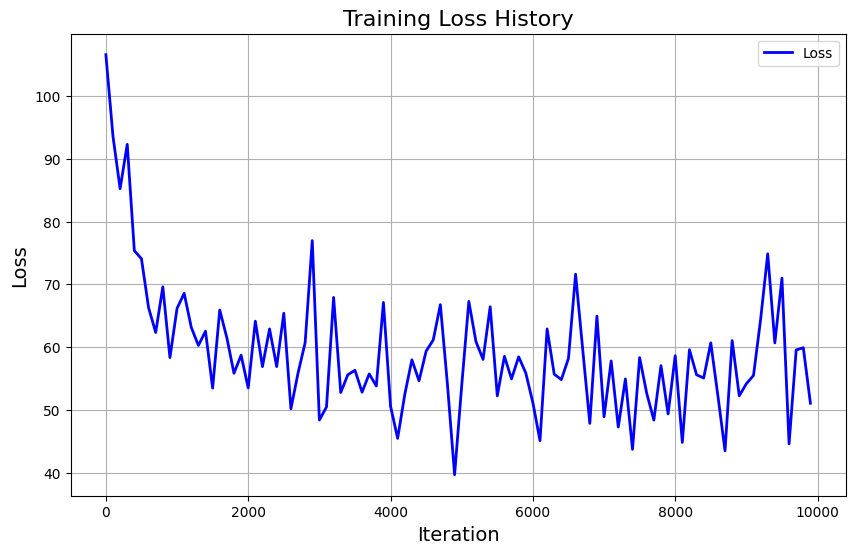

In [32]:
def plot_loss(loss_history, iteration_step=100):
    """
    Plots the loss history over the training iterations to visualize the training process.

    Arguments:
    loss_history -- A list of loss values during training.
    iteration_step -- The number of iterations between each recorded loss value (default 100).
    """
    iterations = [i * iteration_step for i in range(len(loss_history))]  # Multiply iterations by 100
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, loss_history, label='Loss', color='b', lw=2)
    plt.title('Training Loss History', fontsize=16)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot the loss history
plot_loss(loss_history)


In [33]:
def generate_text(model, seed_char, length, idx_to_char):
    """
    Generates text from the trained RNN model given a seed character.

    Arguments:
    model -- The trained RNN model.
    seed_char -- The character to start the generation.
    length -- The length of the generated text.
    idx_to_char -- A dictionary mapping indices to characters.

    Returns:
    generated_text -- A string containing the generated text.
    """
    seed_idx = char_to_idx[seed_char]  # Get the index of the seed character
    h_prev = np.zeros((model.hidden_size, 1))  # Initialize the hidden state
    generated_text = model.sample(h_prev, seed_idx, length, idx_to_char)  # Generate the text
    return generated_text

# Generate text after training the model
seed_char = 'H'  # The character to start the generation
length = 500
generated_text = generate_text(rnn_model, seed_char, length, idx_to_char)

print(seed_char + generated_text)

He fs iid thistevecce fusam weacin eing rerinhlr .xbetewt ole tlor farer shel .I of lintion thobllutse hat srepich andexms HA wlanp gror kame nowl bet gord hiV chis deed thablot e pruthhs thod ack of fotoulp u ves doms Gike .Ift ansext fat Har only madn done ig a had osmef whepieth as nels and ha pery hy reshedud erd hist afinonm door to deny fat fraendedss wapha As soth the wapstgorgefedse he tosh whas .O Der Aloory thin as ?Thulr e satfouner a fiver quaros uy lous Ind Fust wintinntr I ?al whe f
